
<html>

   <head>
      <title>Font Face</title>
   </head>

   <body>
      <font face = "Comic sans MS" size =" 9">Do some Text Mining in INSA</font><br />
   </body>

</html>
![logo_insa](../www/logo_insa.png)
First of all, create a folder on your computer following this structure : 

```
project
│   README.md   
│
└───notebook
│   │   INSA from scratch.ipynb
│   
└───data
│   │   reviews_airlines.csv
│   
└───output
│   │   Myfiles.pckle
│   
└───wwww
    │   logo_insa.png
    
```


## TOC:
* [Import data, cleaning and visualizing](#first-bullet)  
    - [Visualizing](#visual)
* [Preprocessing](#preprocessing)
* [Topic Modeling](#topic-modeling)
    - [Dimension reduction with NMF algorithm](#nmf)
    - [LDA](#lda)
* [Predict my rate !](#predict-rate)
    - [Regression](#regression)
    - [Classification](#classification)
* [Source](#source)

In [72]:
import pandas as pd
import numpy as np
import datetime
import os
import math

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn import preprocessing
import string
import gensim
from gensim import corpora
from gensim.models import phrases, Phrases, coherencemodel
from nltk import word_tokenize
from tqdm import tqdm # for progress bar
from tqdm import tqdm_notebook
tqdm.pandas(desc='progress-bar')
tqdm_notebook().pandas()
import langdetect # to detect language
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,f1_score,mean_squared_error,r2_score
from sklearn.pipeline import Pipeline

import seaborn as sns
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
%matplotlib inline


import pickle
import itertools

In [ ]:
# nltk.download('punkt')
# nltk.download('wordnet')

## Import data, cleaning and visualizing <a class="anchor" id="first-bullet"></a>

In [15]:
airlines = pd.read_csv('../data/reviews_airlines.csv',sep=',',encoding='latin')

In [16]:
airlines.head()

,cabin,content,date,destination,rating,route,title,source
0,Economy,"Easy check in, limited delay but plane was rel...",2018-09-25,Bristol - Pula,4.0,Europe,"Cheap, easy flight",easyjet
1,Economy,NaN,NaN,Bristol - Pula,NaN,Europe,NaN,easyjet
2,Economy,"We do not fly very often, so were a little fri...",2018-09-25,Prague - London,4.0,Europe,Return to UK,easyjet
3,Economy,"We do not fly very often, so were a little fri...",2018-09-25,London - Prague,4.0,Europe,Prague,easyjet
4,Economy,"Very positive experience. Fast service, clear ...",2018-09-25,Budapest - Canton of Geneva,5.0,Europe,Very positive,easyjet


In [17]:
print('Number of reviews: ', airlines.shape[0])

Number of reviews:  74435


Now, let's only keep the stars, text and number of the review to work on.
We add the number column in case we change the index later

In [78]:
airlines['number'] = airlines.index
airlines['date'] = pd.to_datetime(airlines['date'])
airlines['month'] = airlines.date.apply(lambda x: x.month)
airlines['year'] = airlines.date.apply(lambda x: x.year)
df = airlines[['number','content','rating','date']].copy()
df = df.dropna()

### Visualizing<a class="anchor" id="visual"></a>

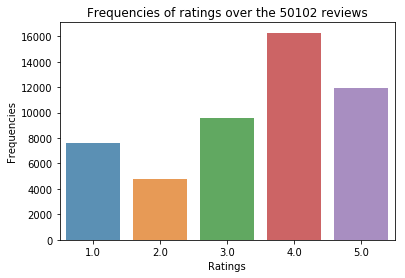

In [19]:
X_ratings = df.rating.value_counts()
ax = sns.barplot(X_ratings.index,X_ratings,alpha=0.8)
ax.set(xlabel='Ratings',ylabel='Frequencies',title='Frequencies of ratings over the {} reviews'.format(df.shape[0]))
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



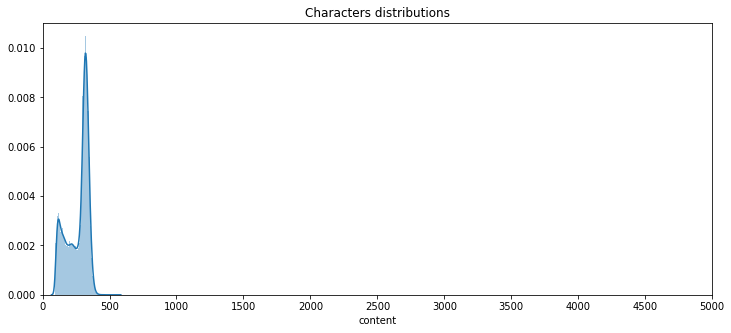

In [7]:
ax = plt.figure(figsize=(12,5))
sns.distplot(df['content'].apply(lambda x:len(str(x))))
plt.title('Characters distributions')
plt.xticks(range(0,5500,500))
plt.show()

Checking the most frequent words in the corpus (except stop words)

In [34]:
stopW = stopwords.words('english')

allWords = []
for sent in df['content'].tolist():
    for word in sent.split():
        wordl=word.lower()
        if wordl not in stopW:
            allWords.append(wordl)
dist = nltk.FreqDist(allWords)

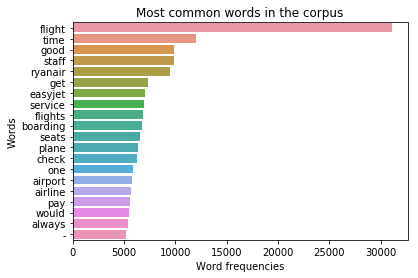

In [35]:
X = [nb[1] for nb in dist.most_common(20)]
y = [nb[0] for nb in dist.most_common(20)]
ax = sns.barplot(X,y)
ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the corpus')
plt.show()

Let's checking the rating evolution by source with a heatmap ! 

In [22]:
df_heatmap = airlines[['source','month','rating']].copy()
df_heatmap = df_heatmap.groupby(['source', 'month']).mean().reset_index()
df_heatmap["source"] = pd.Categorical(df_heatmap["source"], df_heatmap.source.unique())


In [23]:
heatmap_matrix = df_heatmap.pivot("source", "month", "rating")
heatmap_matrix

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
source,,,,,,,,,,,,
easyjet,3.829949,3.866894,3.732381,3.562963,3.769466,3.562100,3.258045,3.615429,3.670475,3.471535,3.463542,3.869271
ryanair,3.123369,3.359918,3.286080,3.188650,3.160332,2.993210,2.686223,3.277718,3.070392,3.254464,2.941545,3.383543
transavia,3.515909,3.622024,3.623077,3.597107,3.462428,3.591216,3.494071,3.562005,3.549451,3.622449,3.754569,3.748276


In [24]:
colorscale = [[0, '#edf8fb'], [.3, '#b3cde3'],  [.6, '#8856a7'],  [1, '#810f7c']]

heatmap = go.Heatmap(z=heatmap_matrix.as_matrix(), x=heatmap_matrix.columns, y=heatmap_matrix.index, colorscale=colorscale)
data = [heatmap]
plotly.offline.iplot(data, filename='basic-heatmap')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



## Preprocessing<a class="anchor" id="preprocessing"></a>
First, we lower the text.
Then, we remove:
- Stop Words
- words with a length less than 2 characters
- punctuation 
- more stopwords based on more frequent words we saw previously and that will not help us for topic extraction

We also use lemmatization on nouns, verbs and adjectives to get more consistent features and reduce the dimensionality of the future matrices

In [21]:
more_stopwords=['flight','staff','airport''n\'t','...','\'ve','\'re']
exclude = set(string.punctuation)
stopW = stopwords.words('english')
lemma = WordNetLemmatizer()

def preprocessing(sent):
    tokens = word_tokenize(sent)
    tokens = [w.lower() for w in tokens if w.lower() not in stopW]   
    tokens = [w for w in tokens if len(w)>2]
    tokens = [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w,pos='a'),pos='v'),pos='n') for w in tokens]
    tokens = [w for w in tokens if w not in exclude]
    tokens = [w for w in tokens if w not in more_stopwords]    
    return tokens

In [9]:
df['tokens'] = df['content'].progress_apply(preprocessing)

Let's save the DataFrame using pickle

In [42]:
with open('../output/content_preprocessed.pickle', 'wb') as output:
    pickle.dump(df, output)

If you want to load the pickle file : 

In [26]:
#with open('../output/content_preprocessed.pickle', 'rb') as input:
#    df = pickle.load(input)

Let's add the bigrams too

In [43]:
tokens = df['tokens'].tolist()
bigram =  Phrases(tokens, min_count = 10)
bigram_mod = phrases.Phraser(bigram)
allTokens = list([bigram_mod[tokens]])
allTokens = [[t for t in token if t not in stopW] for token in allTokens]

Let's save the tokens and check the first few tokens

In [45]:
with open('../output/allTokens.pickle', 'wb') as output:
    pickle.dump(allTokens, output)

If you want to load the pickle file : 

In [27]:
#with open('../output/allTokens.pickle', 'rb') as input:
#    allTokens = pickle.load(input)

In [ ]:
allTokens[:10]

## Topic Modeling<a class="anchor" id="topic-modeling"></a>

### Dimension reduction with NMF algorithm<a class="anchor" id="nmf"></a>

Less powerful than LDA, NMF gives us a quick way to visualize topics

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english') # set the parameters for automatic selection of words

In [29]:
TermDocument = tfidf_vectorizer.fit_transform(df.content) # feed with your articles

In [30]:
n_dimensions = 6 # This can also be interpreted as topics in this case. This is the "beauty" of NMF. 6 is arbitrary
nmf = NMF(n_components=n_dimensions, random_state=42, alpha=.1, l1_ratio=.5).fit(TermDocument) 

In [31]:
W = nmf.fit_transform(TermDocument)
H = nmf.components_

In [32]:
words = tfidf_vectorizer.get_feature_names()
n_top_words = 10 # print 10 words by dimension. You can change this number

# Loop for each dimension: what words are the most dominant in each dimension
for i_dimension, dimension in enumerate(nmf.components_):
    print("Topic #%d:" % i_dimension)
    print(" ".join([words[i] for i in dimension.argsort()[:-n_top_words - 1:-1]]))
print()

Topic #0:
ryanair airline flights fly cheap low times cost easyjet budget
Topic #1:
luggage extra boarding seats hand priority pay seat bag paid
Topic #2:
flight delayed time hour late airport hours minutes plane delay
Topic #3:
staff friendly helpful crew time cabin flight great clean pleasant
Topic #4:
easy jet check online booking quick boarding airport use drop
Topic #5:
good service value flight price money food time board overall



### Latent Dirichlet Allocation (LDA) <a class="anchor" id="lda"></a>
*Tips* : conda install -c conda-forge pyldavis

select_corpus() is a function to return all words in a single List, that we will use for LDA

In [33]:
def select_corpus():
    allWords=[]
    for sent in allTokens:
        for word in sent:
            allWords.append(word)
    return allWords

In [34]:
tokens_for_lda = select_corpus()
dictionary = corpora.Dictionary(tokens_for_lda)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokens_for_lda]

In [35]:
number_of_topics = 6
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix,num_topics = number_of_topics, id2word = dictionary,passes=4,random_state=42,alpha=[0.1]*number_of_topics,eta=[0.01]*len(dictionary))

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [36]:
ldamodel.save('../output/lda6.model')
#ldamodel = gensim.models.ldamodel.LdaModel.load('../output/lda6.model')

In [38]:
### set lambda to 0.6
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
reviews_vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(reviews_vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




Avec un Lambda = 0.17
Try to understand groups : 
- Topic 1 : Ce topic représente tout ce qui touche autour de l'avion => Aeroport 
- Topic 4 : Ce topic représente tous les mots qui touche aux plaintes. 
- Topic 3 : Ce topic représente la cause des plaintes 
- Topic 2 et 5 : Tout ce qui est liée aux choses positive  
Donc sur la PC1, nous avons l'avis des personnes. A gauche, nous avons les sentiments +, et à droite, les sentiments -


In [39]:
#Careful, number assigned to a topic is different from real ldamodel to pyLDAvis 
topics = ldamodel.show_topics()
for i, el in topics:
    print('{} : \n{}\n'.format(i,el))

0 : 
0.040*"hour" + 0.040*"delay" + 0.020*"airport" + 0.020*"late" + 0.017*"get" + 0.013*"wait" + 0.012*"time" + 0.011*"arrive" + 0.011*"plane" + 0.010*"one"

1 : 
0.021*"check" + 0.020*"luggage" + 0.017*"board" + 0.016*"bag" + 0.014*"seat" + 0.014*"take" + 0.013*"get" + 0.013*"plane" + 0.012*"one" + 0.011*"n't"

2 : 
0.046*"seat" + 0.029*"pay" + 0.027*"get" + 0.023*"n't" + 0.021*"cheap" + 0.018*"price" + 0.018*"airline" + 0.017*"ryanair" + 0.014*"good" + 0.011*"extra"

3 : 
0.041*"fly" + 0.037*"time" + 0.033*"good" + 0.025*"airline" + 0.024*"service" + 0.022*"ryanair" + 0.020*"always" + 0.015*"price" + 0.014*"travel" + 0.014*"great"

4 : 
0.062*"time" + 0.041*"good" + 0.026*"friendly" + 0.026*"board" + 0.025*"service" + 0.021*"nice" + 0.018*"crew" + 0.016*"land" + 0.016*"great" + 0.016*"arrive"

5 : 
0.056*"book" + 0.035*"fly" + 0.031*"easy" + 0.028*"use" + 0.028*"check" + 0.025*"time" + 0.023*"airport" + 0.021*"airline" + 0.019*"ryanair" + 0.018*"online"



## Predict my rate ! <a class="anchor" id="predict-rate"></a>

#### Méthodologie

Dans les commentaires scrappés, une note globale (rating) est donnée a la compagnie aérienne. 

L'idée du projet est donc de réussir à prédire la note en fonction du commentaire de la personne. 
Une idée d'application sur ce genre d'algorithme serait de :
- détecter les cas où les commentaires laissent penser que l'évaluation est mauvaise alors que la note indiquée est très bonne (détéction d'anomalie)
- créer un modèle capable de donner le sentiment positif, ou négatif d'un commentaire

Soit $X$ le commentaire laissé en langage naturel. Soit $Y$ la note (rating), $Y\in\{1,...,5\}$. Une note de 1 est une mauvaise note, à l'inverse 5 est la meilleure note. 



### Difficultés liées à cette modélisation 

* Les notes ont une relation de rang qu'il faut conserver. Une note de 1 est inférieure à une note de 2. En utilisant un modèle de classification à 5 classes, cette relation de rang ne sera pas conservée. 
* Il y a une fluctuation sur la note attribuée car les personnes qui notent ne le font pas selon la même méthdologie. Une personne qui a mis 1 aurait tout aussi bien pu mettre une note de 2. 
* Le commentaire peut ne pas concerner l'appréciation globale de la compagnie. Dans ce cas, il n'y a pas vraiment de lien entre la note et le commentaire. Ces données viendront donc affaiblir l'estimation du modèle. 
* Les notes ne sont pas équiréparties. Il y a plus de bonnes notes que de mauvaises notes. L'estimation devra tenir compte de cet élément en créant des classes qui possèdent le même nombre d'éléments pour éviter le surapprentissage sur les notes les plus représentées. 
* les commentaires sont écrits en langage naturel et doivent donc être nettoyés et transformés en features avant d'être intégrés au modèle de probabilité. 

Pour chacune de ces difficultés, nous allons construire une méthodologie permettant de les surmonter afin de construire le modèle globale qui servira à l'analyse. 

#### Construction d'une méthode d'échantillonnage 

In [49]:
# Fonction permettant de créer un échantillon de df pour lesquels les classes renseignées dans la colonne
# column ont le même nombre d'éléments
def custom_stratified(df,column):
    # TODO : retourner également le dataframe des éléments qui ne font pas partie de l'échantillon. 
    pop = df.groupby(['rating']).count().reset_index()
    N = pop.loc[pop['number'].idxmin()]['content']
    
    return pd.concat([
        df[df[column] == c].sample(N) for c in df[column].unique()
    ])

#### Construction d'un modèle qui maintienne la relation de rang

#### Modèle de régression <a class="anchor" id="regression"></a>

La régression, dans la mesure où elle considère la variable à prédire comme une variable numérique tient compte par nature de la relation de rang. Une régression pourra donc être utilisée pour prédire la note. 


In [64]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=preprocessing,ngram_range=(1,2))),
    ('tfidf',TfidfTransformer()),
    ('clf', LinearRegression())
])

In [79]:
dict_split_class = {i:str(math.ceil(i/2)) for i in range(1,6)}
df_regression = df.replace({'rating':dict_split_class})
df_regression['rating'] = df_regression.rating.astype(int)
df = custom_stratified(df_regression,'rating')
train, test = train_test_split(df, test_size=0.2)
big_test = df_regression.loc[df_regression.index.difference(df.index.values)] # use data not use in split data for test 
#test = big_test
train.groupby(['rating']).count()

,number,content,date
rating,,,
1,9498,9498,9498
2,9498,9498,9498
3,9554,9554,9554


###### Training part

In [80]:
train_text = train['content'].values
train_y = train['rating'].values.astype(int)
    
test_text = test['content'].values
test_y = test['rating'].values.astype(int)
    
pipeline.fit(train_text,train_y)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...e_idf=True)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

###### Prediction part

In [81]:
predictions = pipeline.predict(test_text)

In [82]:
def float_to_int_regression(x):
    return int(round(x))
    
# define vectorized float_to_int_regression
float_to_int_regression_v = np.vectorize(float_to_int_regression)
predictions_int = float_to_int_regression_v(predictions)

# replace max (resp. min) prediction by the maximum (resp. min) of the class 
predictions_int[predictions_int >max(test_y)] = max(test_y)
predictions_int[predictions_int < min(test_y)] = min(test_y)

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

Confusion matrix, without normalization
Normalized confusion matrix


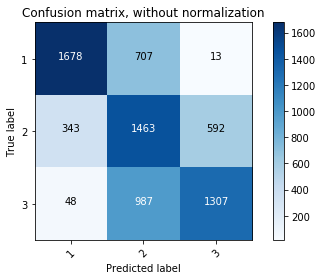

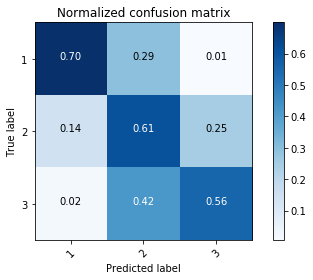

In [84]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, predictions_int)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=set(train_y),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=set(train_y), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
comparaison = test.copy() 
comparaison['y'] = predictions_int
#comparaison.to_excel('./comparaison.xls',encoding='utf-8')

#### Live prediction

In [92]:
pipeline.predict(["bad company"])

array([0.6])

#### Modèle de classification <a class="anchor" id="regression"></a>

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=preprocessing,ngram_range=(1,2))),
    ('tfidf',TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1))
])

...

## Brouillon

## Source <a class="anchor" id="source"></a>

[How to create a heatmap](https://blog.algorexhealth.com/2017/09/10-heatmaps-10-python-libraries/)